## 11. 시계열 분석 방법 응용

이번 노트에서는 시계열 분석 방법을 응용한 회귀분석, VAR, 주파수 분해 기법 적용 사례를 예제 코드를 통해 확인합니다.

In [30]:
# 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
from lesson3 import setup_korean_font
setup_korean_font()

# 시계열 분석 라이브러리
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.datasets import macrodata
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import fft

# 평가 지표
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 랜덤 시드 설정
np.random.seed(42)

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'AppleGothic'

이번 분석에서 사용할 데이터는 statsmodel 패키지에 수록된 macrodata입니다.  
이 데이터는 1959~2009 사이의 미국 경제 데이터를 분기별로 담은 데이터셋입니다. 분석을 간결하게 하기 위해서 이론적으로나 실증적으로 인과관계가 확인된 실질소비와 실질GDP 데이터를 이용하겠습니다.

In [46]:
# 데이터 로딩
df = macrodata.load_pandas().data[['realgdp', 'realcons']].copy()

# 회귀분석용 데이터 생성 (GDP 항등식: GDP = 소비 + 투자 + ...)
Y = df['realgdp'].values.astype(float)  # Y = GDP (종속변수)
X = df['realcons'].values.astype(float)  # X = 소비 (독립변수)
Xc = sm.add_constant(X)

print(f"데이터 shape: {df.shape}")
print(f"변수: {df.columns.tolist()}")
df.head()

데이터 shape: (203, 2)
변수: ['realgdp', 'realcons']


,realgdp,realcons
0,2710.349,1707.4
1,2778.801,1733.7
2,2775.488,1751.8
3,2785.204,1753.7
4,2847.699,1770.5


### 11.1. 회귀분석을 활용한 시계열 데이터 분석

In [48]:
# OLS 회귀모형을 적합하고 잔차에 자기상관이 있는지 검정
ols_model = sm.OLS(Y, Xc)
ols_res = ols_model.fit()
resid_ols = ols_res.resid
DW_ols = durbin_watson(resid_ols)

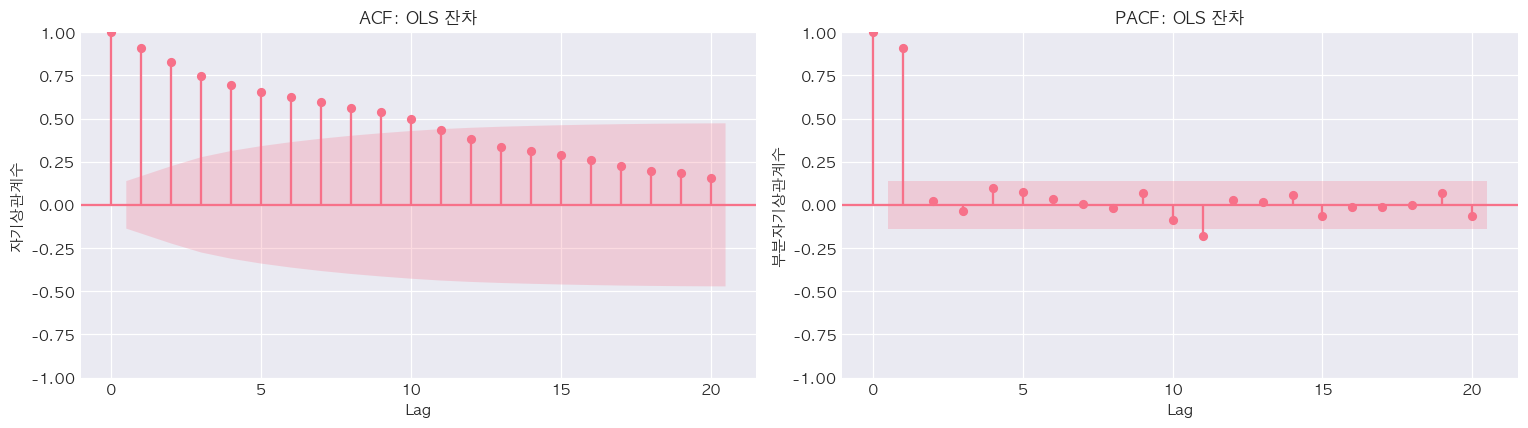

In [49]:
# OLS 잔차의 자기상관 구조 진단
## ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

### ACF
plot_acf(resid_ols, lags=20, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: OLS 잔차', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('자기상관계수')

### PACF
plot_pacf(resid_ols, lags=20, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF: OLS 잔차', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('부분자기상관계수')

plt.tight_layout()
plt.show()

In [50]:
# 코크란-오컷 방법 적용
## CO 방법은 PW 방법과 달리 p차 이전의 주기 데이터를 제거하는 분석 방법입니다.
## 잔차의 자기상관구조를 봤을 때 AR(10) 또는 AR(2)를 적용하는 것이 좋을 것 같지만, 간단한 분석 목적이기 때문에 연산량이 적고 덜 복잡한 AR(1)을 적용하겠습니다.

## rho 추정
rho_hat = np.dot(resid_ols[1:], resid_ols[:-1]) / np.dot(resid_ols[:-1], resid_ols[:-1])

## Cochrane–Orcutt 방법을 적용하여 회귀모형 적합
Y_co = Y[1:] - rho_hat * Y[:-1] # 첫 관측치 제거
Xc_co = Xc[1:, :] - rho_hat * Xc[:-1, :] # 첫 관측치 제거
co_res = sm.OLS(Y_co, Xc_co).fit()
resid_co = co_res.resid
DW_co = durbin_watson(resid_co)

추정된 AR(1) rho: 0.9516
계수 비교 (절편, 기울기):
  OLS              : (520.4253, 1.3887)
  Cochrane–Orcutt  : (764.4531, 1.3415)

표준오차 비교 (절편 SE, 기울기 SE):
  OLS              : (20.5829, 0.0038)
  Cochrane–Orcutt  : (153.4702, 0.0250)

Durbin-Watson (잔차 자기상관 지표):
  OLS              : 0.1280
  Cochrane–Orcutt  : 2.0835

정상성 ADF p-value:
  GDP(realgdp)   : p=0.9982 (비정상)
  소비(realcons): p=0.9977 (비정상)


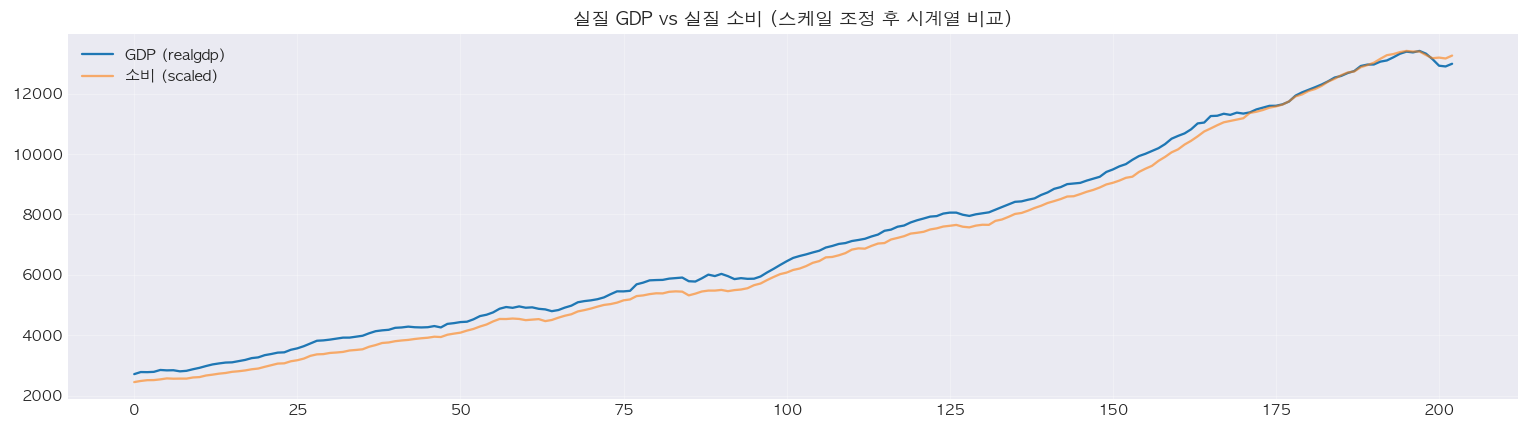

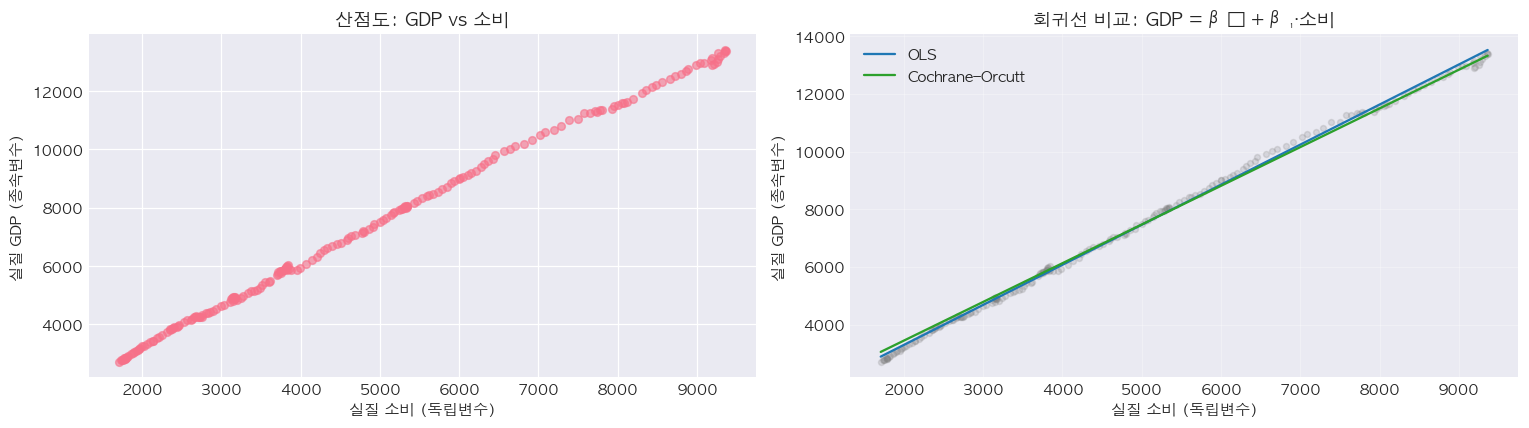

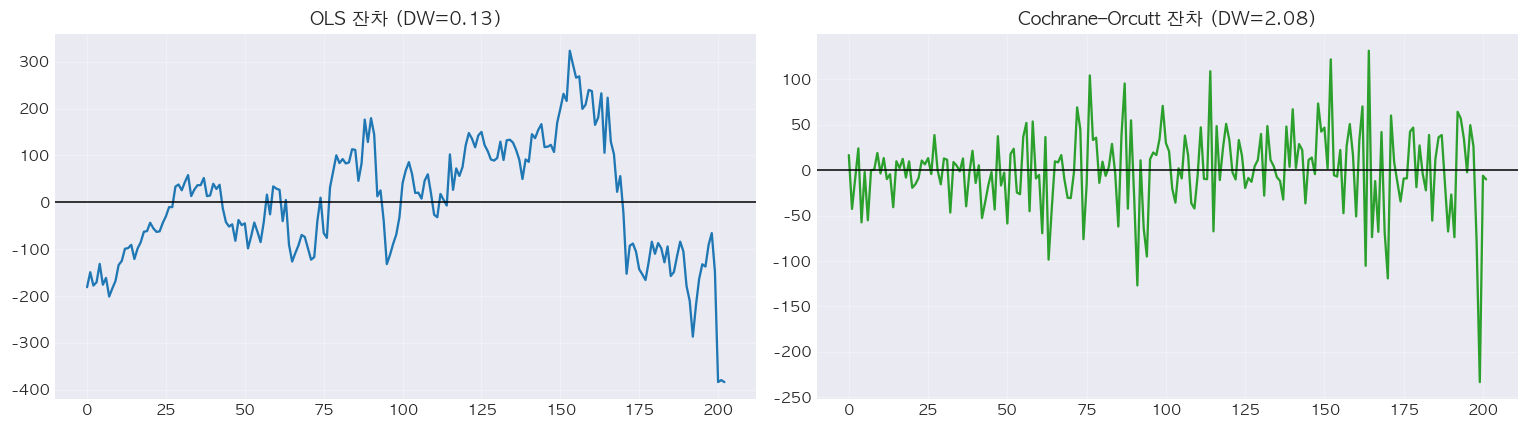

In [51]:
# OLS vs Cochrane–Orcutt 비교
print(f"추정된 AR(1) rho: {rho_hat:.4f}")
print("계수 비교 (절편, 기울기):")
print(f"  OLS              : ({ols_res.params[0]:.4f}, {ols_res.params[1]:.4f})")
print(f"  Cochrane–Orcutt  : ({co_res.params[0]:.4f}, {co_res.params[1]:.4f})")
print()
print("표준오차 비교 (절편 SE, 기울기 SE):")
print(f"  OLS              : ({ols_res.bse[0]:.4f}, {ols_res.bse[1]:.4f})")
print(f"  Cochrane–Orcutt  : ({co_res.bse[0]:.4f}, {co_res.bse[1]:.4f})")
print()
print("Durbin-Watson (잔차 자기상관 지표):")
print(f"  OLS              : {DW_ols:.4f}")
print(f"  Cochrane–Orcutt  : {DW_co:.4f}")
print()

# 정상성 검정 (경고 목적)
adf_y = adfuller(Y, autolag='AIC')[1]
adf_x = adfuller(X, autolag='AIC')[1]
print("정상성 ADF p-value:")
print(f"  GDP(realgdp)   : p={adf_y:.4f} {'(비정상)' if adf_y>0.05 else '(정상)'}")
print(f"  소비(realcons): p={adf_x:.4f} {'(비정상)' if adf_x>0.05 else '(정상)'}")

# 시각화
plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(14,4))
plt.plot(Y, label='GDP (realgdp)', color='tab:blue')
plt.plot(X * (Y.max()/X.max()), label='소비 (scaled)', color='tab:orange', alpha=0.6)
plt.title('실질 GDP vs 실질 소비 (스케일 조정 후 시계열 비교)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].scatter(X, Y, alpha=0.6, s=25)
axes[0].set_xlabel('실질 소비')
axes[0].set_ylabel('실질 GDP')
axes[0].set_title('산점도: GDP vs 소비')

x_line = np.linspace(X.min(), X.max(), 200)
y_ols_line = ols_res.params[0] + ols_res.params[1]*x_line
y_co_line = co_res.params[0] + co_res.params[1]*x_line
axes[1].plot(x_line, y_ols_line, label='OLS', color='tab:blue')
axes[1].plot(x_line, y_co_line, label='Cochrane–Orcutt', color='tab:green')
axes[1].scatter(X, Y, alpha=0.2, s=15, color='gray')
axes[1].set_title('회귀선 비교: GDP = β₀ + β₁·소비')
axes[1].set_xlabel('실질 소비')
axes[1].set_ylabel('실질 GDP')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 잔차 비교
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].plot(resid_ols, color='tab:blue')
axes[0].axhline(0, color='black', lw=1)
axes[0].set_title(f'OLS 잔차 (DW={DW_ols:.2f})')
axes[0].grid(alpha=0.3)

axes[1].plot(resid_co, color='tab:green')
axes[1].axhline(0, color='black', lw=1)
axes[1].set_title(f'Cochrane–Orcutt 잔차 (DW={DW_co:.2f})')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
# Prais–Winsten 방법 적용 (소비 = f(GDP))

## OLS 적합 및 rho 초기 추정
ols = sm.OLS(Y, Xc).fit()
e = ols.resid
rho_hat = float(np.dot(e[1:], e[:-1]) / np.dot(e[:-1], e[:-1]))

## PW 방법을 위한 데이터 변환 
Y_pw = Y.copy(); Xc_pw = Xc.copy()
Y_pw[1:] = Y[1:] - rho_hat * Y[:-1]
Xc_pw[1:, :] = Xc[1:, :] - rho_hat * Xc[:-1, :]

## 1기 시점 관측치 보정
### PW 방법은 p차 이전의 관측치를 일정한 가중치에 따라 보정하여 버리지 않고 사용합니다.
### 데이터 수가 적을 때에 CO보다 PW가 유리한 지점이고, 이 때문에 분석 결과에서도 차이가 발생합니다.
scale = np.sqrt(max(1e-12, 1 - rho_hat**2))
Y_pw[0] = scale * Y[0]
Xc_pw[0, :] = scale * Xc[0, :]

## 모형 적합
pw = sm.OLS(Y_pw, Xc_pw).fit()
resid_pw = pw.resid

## 잔차의 자기상관성 검증
DW_pw  = durbin_watson(resid_pw)

print("="*72)
print(f"{'방법':<20}{'절편':>12}{'기울기':>12}{'SE(절편)':>12}{'SE(기울기)':>12}{'DW':>10}")
print("-"*72)
print(f"{'OLS':<20}{ols.params[0]:>12.4f}{ols.params[1]:>12.4f}{ols.bse[0]:>12.4f}{ols.bse[1]:>12.4f}{DW_ols:>10.3f}")
print(f"{'Cochrane–Orcutt':<20}{co.params[0]:>12.4f}{co.params[1]:>12.4f}{co.bse[0]:>12.4f}{co.bse[1]:>12.4f}{DW_co:>10.3f}")
print(f"{'Prais–Winsten':<20}{pw.params[0]:>12.4f}{pw.params[1]:>12.4f}{pw.bse[0]:>12.4f}{pw.bse[1]:>12.4f}{DW_pw:>10.3f}")

방법                            절편         기울기      SE(절편)     SE(기울기)        DW
------------------------------------------------------------------------
OLS                     520.4253      1.3887     20.5829      0.0038     0.128
Cochrane–Orcutt        -156.0259      0.6954    120.2011      0.0133     2.084
Prais–Winsten           588.5579      1.3656    121.3864      0.0215     2.087


### 11.2. VAR (Vector AutoRegression) 모형

전통적인 VAR 모형 역시 안정 시계열을 전제로 전개됩니다. 이를 위해 STL을 이용하여 추세와 계절요인을 분해한 후 잔차요인에 대해 VAR을 적합하는 예제코드입니다.

In [55]:
# STL 분해 (period=4, 분기 데이터)
period = 4
cols_var = df.columns.tolist()  # ['realgdp', 'realcons']

stl_var_results = {}
for col in cols_var:
    series_full = df[col].astype(float)
    stl_obj = STL(series_full, period=period, robust=True).fit()
    stl_var_results[col] = {
        'trend': stl_obj.trend,
        'seasonal': stl_obj.seasonal,
        'remainder': stl_obj.resid
    }

## 잔차요인을 기초로 데이터프레임 생성
df_var_resid = pd.DataFrame({c: stl_var_results[c]['remainder'] for c in cols_var}, index=df.index)
print(f"\n잔차(remainder) DataFrame 생성: {df_var_resid.shape}")
print(df_var_resid.head())


잔차(remainder) DataFrame 생성: (203, 2)
     realgdp  realcons
0  -8.030794 -1.139804
1   4.599742 -3.452585
2  -2.315511  4.963575
3   4.647170 -1.436094
4  48.207118  6.654900


In [58]:
# Durbin-Watson 기반 휴리스틱으로 VAR 차수 p 결정
## 여러 차수(p)로 VAR 모델을 적합하고, 각 모델 잔차의 DW 통계량을 계산한 후,
## DW가 2에 가장 가까운 차수를 선택하는 방식으로 p를 선택하는 분석 기법입니다.

# Train/Test 분할 (전체 잔차 데이터 기준)
train_size_var = int(len(df_var_resid) * 0.8)
train_var = df_var_resid.iloc[:train_size_var]

# 여러 차수로 VAR 적합 후 DW 계산
model_var = VAR(train_var)
max_p = min(12, len(train_var) // 5)  # 최대 차수 제한

dw_results = {}
print(f"\n{'p':<4}{'평균 DW':>12}{'abs(DW-2)':>12}")
print("-"*28)

for p in range(1, max_p + 1):
    try:
        var_fit_temp = model_var.fit(p)
        # 각 변수별 잔차의 DW 계산
        residuals = var_fit_temp.resid
        dw_values = []
        for col in residuals.columns:
            dw = durbin_watson(residuals[col].values)
            dw_values.append(dw)
        
        avg_dw = np.mean(dw_values)
        dw_results[p] = {
            'avg_dw': avg_dw,
            'dev_from_2': abs(avg_dw - 2.0),
            'dw_by_var': dict(zip(residuals.columns, dw_values))
        }
        
        print(f"{p:<4}{avg_dw:>12.4f}{abs(avg_dw - 2.0):>12.4f}")
    except:
        continue

# DW가 2에 가장 가까운 차수 선택
p_dw = min(dw_results.keys(), key=lambda p: dw_results[p]['dev_from_2'])
best_dw = dw_results[p_dw]['avg_dw']


p          평균 DW   abs(DW-2)
----------------------------
1         1.9567      0.0433
2         2.0101      0.0101
3         2.0329      0.0329
4         2.0062      0.0062
5         2.0221      0.0221
6         2.0021      0.0021
7         2.0089      0.0089
8         1.9833      0.0167
9         2.0041      0.0041
10        2.0174      0.0174
11        2.0009      0.0009
12        1.9854      0.0146


In [64]:
# Test 데이터 분할
test_var = df_var_resid.iloc[train_size_var:]

print(f"\n훈련 데이터: {len(train_var)}개 ({train_var.index[0]} ~ {train_var.index[-1]})")
print(f"테스트 데이터: {len(test_var)}개 ({test_var.index[0]} ~ {test_var.index[-1]})")


훈련 데이터: 162개 (0 ~ 161)
테스트 데이터: 41개 (162 ~ 202)


In [61]:
# VAR(11) 적합
model_var = VAR(train_var)
var_fit = model_var.fit(p_dw)

print(var_fit.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Nov, 2025
Time:                     10:18:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.6854
Nobs:                     151.000    HQIC:                   13.1397
Log likelihood:          -1346.37    FPE:                    351882.
AIC:                      12.7663    Det(Omega_mle):         265004.
--------------------------------------------------------------------
Results for equation realgdp
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -1.443208         2.774861           -0.520           0.603
L1.realgdp           0.215745         0.094708            2.278           0.023
L1.realcons          0.405515         0.156729            2.58

In [65]:
# 그랜저 인과관계 검정
max_lag_gc = min(4, p_dw)

for col1 in df_var_resid.columns:
    for col2 in df_var_resid.columns:
        if col1 != col2:
            print(f"\n{col1} → {col2} 인과관계 검정:")
            test_data_gc = df_var_resid[[col2, col1]].iloc[:train_size_var]
            try:
                result_gc = grangercausalitytests(test_data_gc, max_lag_gc, verbose=False)
                p_vals = [result_gc[i+1][0]['ssr_ftest'][1] for i in range(max_lag_gc)]
                min_p_gc = min(p_vals)
                if min_p_gc < 0.05:
                    print(f"  ✅ 인과관계 존재 (최소 p={min_p_gc:.4f})")
                else:
                    print(f"  ❌ 인과관계 없음 (최소 p={min_p_gc:.4f})")
            except Exception as e:
                print(f"  ⚠️ 검정 실패: {e}")



realgdp → realcons 인과관계 검정:
  ✅ 인과관계 존재 (최소 p=0.0131)

realcons → realgdp 인과관계 검정:
  ✅ 인과관계 존재 (최소 p=0.0000)


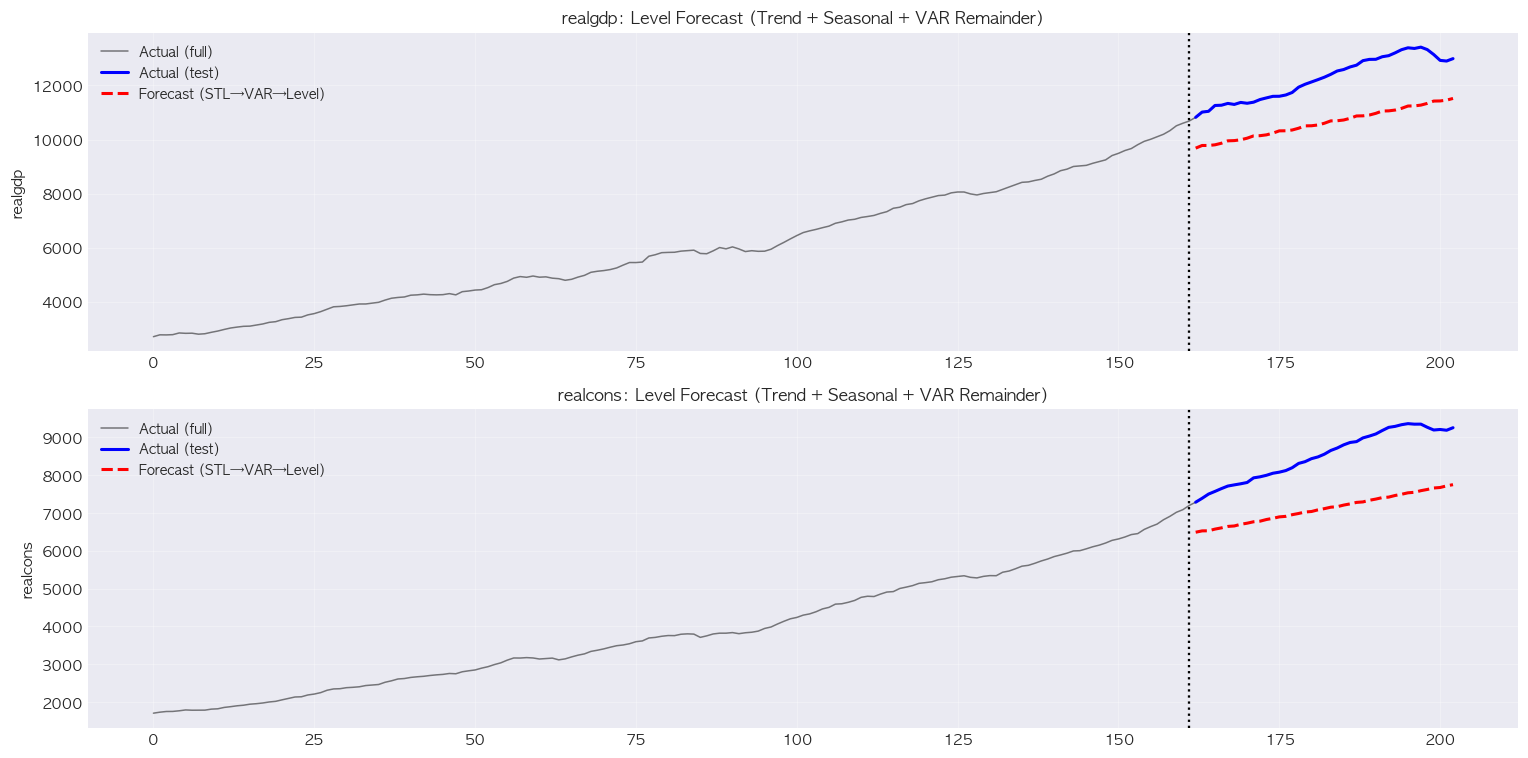

In [68]:
# 테스트 데이터를 이용한 및 STL 성분 병합
steps_test = len(test_var)
forecast_var = var_fit.forecast(train_var.values[-p_dw:], steps=steps_test)
forecast_var_df = pd.DataFrame(forecast_var, index=test_var.index, columns=train_var.columns)

# 추세와 계절 성분 외삽
def linear_extrapolate(series, test_len):
    """선형 회귀로 추세 외삽"""
    y = series.dropna().values
    x = np.arange(len(y))
    coef = np.polyfit(x, y, 1)
    x_future = np.arange(len(y), len(y) + test_len)
    return np.polyval(coef, x_future)

def repeat_seasonal(series, period, test_len):
    """마지막 주기 반복"""
    last_cycle = series.iloc[-period:].values
    reps = int(np.ceil(test_len / period))
    return np.tile(last_cycle, reps)[:test_len]

# 각 변수별 레벨 예측 (trend_forecast + seasonal_forecast + remainder_forecast)
level_forecast_dict = {}
for col in cols_var:
    # 훈련 구간 추세/계절
    trend_train = stl_var_results[col]['trend'].iloc[:train_size_var]
    seasonal_full = stl_var_results[col]['seasonal'].iloc[:train_size_var]
    
    # 외삽
    trend_test = linear_extrapolate(trend_train, steps_test)
    seasonal_test = repeat_seasonal(seasonal_full, period, steps_test)
    remainder_test = forecast_var_df[col].values
    
    # 레벨 복원: trend + seasonal + remainder
    level_forecast = trend_test + seasonal_test + remainder_test
    level_forecast_dict[col] = level_forecast

level_forecast_df = pd.DataFrame(level_forecast_dict, index=test_var.index)

# 실제 레벨 값 (test 구간)
actual_level_test = df.loc[test_var.index, cols_var]

# 시각화: 레벨 예측 vs 실제
fig, axes = plt.subplots(len(cols_var), 1, figsize=(14, 3.5*len(cols_var)))
if len(cols_var) == 1:
    axes = [axes]

for i, col in enumerate(cols_var):
    # 전체 실제 레벨 (train+test)
    axes[i].plot(df.index, df[col], label='Actual (full)', color='black', alpha=0.5, linewidth=1)
    # 테스트 구간 실제
    axes[i].plot(actual_level_test.index, actual_level_test[col], 
                 label='Actual (test)', color='blue', linewidth=2)
    # 레벨 예측
    axes[i].plot(level_forecast_df.index, level_forecast_df[col], 
                 label='Forecast (STL→VAR→Level)', color='red', linestyle='--', linewidth=2)
    axes[i].axvline(x=train_var.index[-1], color='black', linestyle=':', linewidth=1.5)
    axes[i].set_title(f'{col}: Level Forecast (Trend + Seasonal + VAR Remainder)', fontsize=11)
    axes[i].set_ylabel(col)
    axes[i].legend(loc='best', fontsize=9)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 11.3. 주파수 분석

실질GDP 데이터를 이용하여 주파수 분석을 수행하는 예제입니다.  
실질GDP 데이터는 추세 요인이 매우 강하게 나타나는 시계열 데이터입니다. 이 때문에 비정상 요인을 추출하는 방식으로 EMD를 수행한 후, 계절요인보다 낮은 주파수 대역으로 구성된 정상 데이터를 추출하여 FFT를 수행하는 순서로 분석을 진행하겠습니다. 

#### 11.3.1. EMD (Empirical Mode Decomposition)

In [91]:
# EMD 수행

## 라이브러리 로딩
from PyEMD import EMD

## 데이터 준비
realgdp_series = df['realgdp'].dropna().values.astype(float)
time_index = np.arange(len(realgdp_series))

## EMD 수행 및 분해
emd = EMD()
IMFs = emd.emd(realgdp_series, time_index)
n_imfs = IMFs.shape[0]
print(f"추출된 IMF 개수: {n_imfs}")

추출된 IMF 개수: 4


In [95]:
## IMF 확인
### 모든 주파수를 추출하고 남은 잔차는 추세의 역할을 합니다.
for i in range(n_imfs):
    mean_val = np.mean(IMFs[i])
    std_val = np.std(IMFs[i])
    range_val = np.ptp(IMFs[i])
    label = f"IMF-{i+1}" if i < n_imfs-1 else "Residue"
    print(f"{label:<8}{mean_val:>12.2f}{std_val:>12.2f}{range_val:>12.2f}")

## 재구성 검증
### 추출한 IMF와 잔차를 모두 합한 결과가 원본 데이터와 동일한지 검증합니다.
reconstructed = np.sum(IMFs, axis=0)
reconstruction_error = np.max(np.abs(realgdp_series - reconstructed))
print(f"\n재구성 오차 (max abs): {reconstruction_error:.6e}")

IMF-1           0.05       27.78      181.09
IMF-2          -5.45       57.75      359.54
IMF-3         -10.49       79.71      352.52
Residue      7237.06     3205.91    10391.98

재구성 오차 (max abs): 1.818989e-12


In [99]:
# 각 IMF의 주기 추정

imf_periods = []

for i in range(n_imfs):
    label = f"IMF-{i+1}" if i < n_imfs-1 else "Residue"
    
    if i < n_imfs - 1:  # 추세 제외
        # 영교차(zero-crossing)로 평균 주기 추정
        ## 영교차란 해당 주파수에서 신호가 0을 지나는 지점을 의미합니다.
        ## IMF는 영교차가 한 번 일어날 때에 반주기가 형성되므로, 이 점을 이용하여 주기를 계산합니다.
        signal = IMFs[i]
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        
        if len(zero_crossings) > 1:
            # 반주기 간격 계산 (분기 단위)
            half_periods_quarters = np.diff(zero_crossings)
            avg_half_period_quarters = np.mean(half_periods_quarters)
            avg_period_years = (avg_half_period_quarters * 2) / 4  # 분기 → 년
            
            imf_periods.append({
                'IMF': label,
                'period_years': avg_period_years,
                'index': i
            })
            
            print(f"{label}: 평균 주기 {avg_period_years:.2f}년")
        else:
            print(f"{label}: 주기 추정 불가")
    else:
        # 추세 성분
        print(f"{label}: 장기 추세 성분")

IMF-1: 평균 주기 0.78년
IMF-2: 평균 주기 2.40년
IMF-3: 평균 주기 5.77년
Residue: 장기 추세 성분


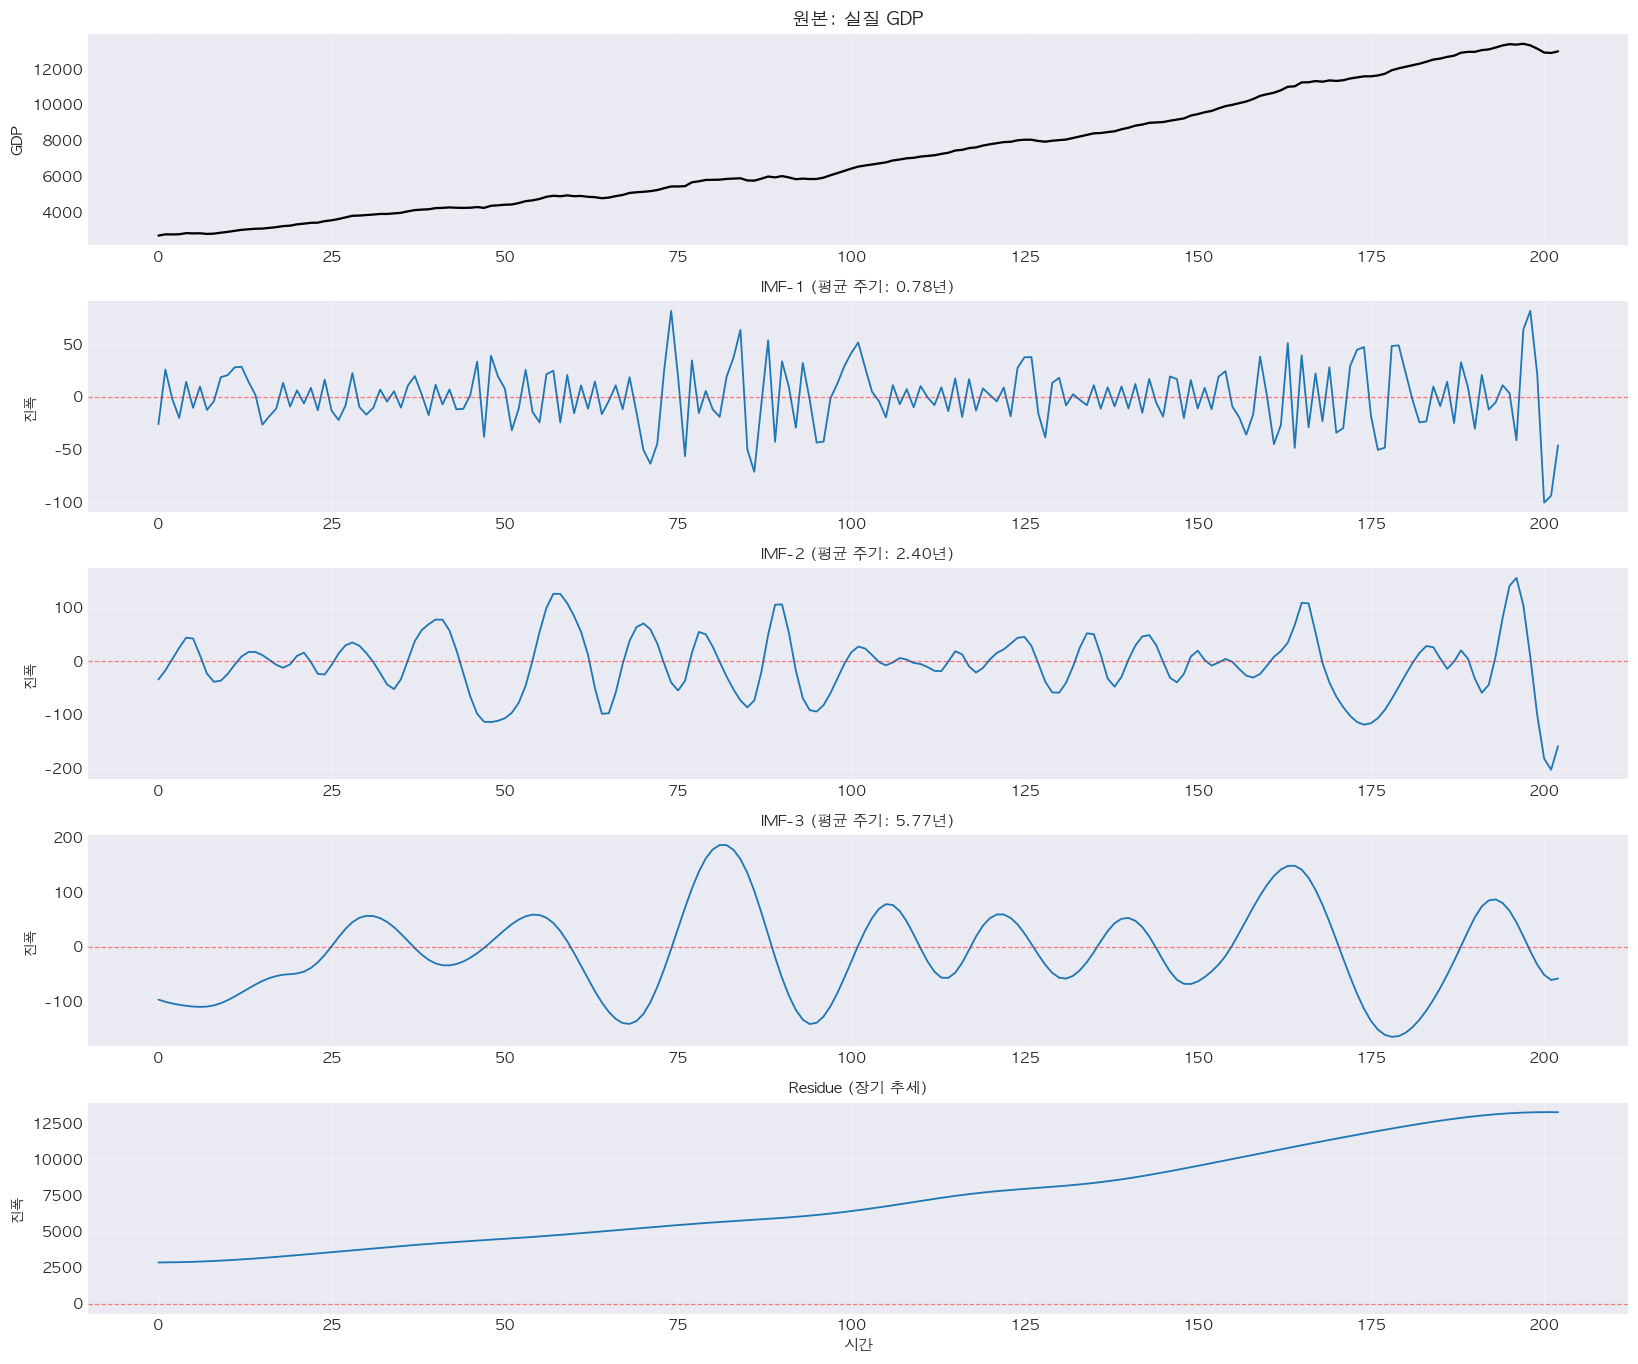

In [100]:
# EMD 분해 결과 시각화
fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(15, 2.5*(n_imfs+1)))

# 원본 시계열
axes[0].plot(df.index, realgdp_series, 'k-', linewidth=1.5)
axes[0].set_title('원본: 실질 GDP', fontsize=12, fontweight='bold')
axes[0].set_ylabel('GDP', fontsize=10)
axes[0].grid(alpha=0.3)

# 각 IMF 시각화
for i in range(n_imfs):
    if i < n_imfs - 1:
        label = f"IMF-{i+1}"
        # 해당 IMF의 주기 정보 찾기
        period_info = next((p for p in imf_periods if p['index'] == i), None)
        if period_info:
            title = f"{label} (평균 주기: {period_info['period_years']:.2f}년)"
        else:
            title = f"{label}"
    else:
        label = "Residue"
        title = "Residue (장기 추세)"
    
    # IMF 플롯
    axes[i+1].plot(df.index, IMFs[i], linewidth=1.2, color='tab:blue')
    axes[i+1].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i+1].set_title(title, fontsize=10, fontweight='bold')
    axes[i+1].set_ylabel('진폭', fontsize=9)
    axes[i+1].grid(alpha=0.3)

axes[-1].set_xlabel('시간', fontsize=10)
plt.tight_layout()
plt.show()

#### 11.3.2. FFT (Fast Fourier Transform)

EMD를 통해 추출한 주파수 중에서 추세, 계절요인에 해당하는 주파수를 제외한 나머지 구간의 주파수만을 이용하여 FFT를 수행하여 다시 한 번 분해합니다.  
EMD의 잔차는 추세요인, IMF-1은 1년에 가까운 주기를 가지기 때문에 계절요인으로 분류하고, 나머지 IMF-2, IMF-3을 결합한 데이터를 이용하여 FFT를 수행하겠습니다.

In [ ]:
## IMF-2, 3을 결합하여 경기순환 성분 추출
business_cycle_imfs = [1, 2]  # IMF-2, IMF-

## IMF들 결합
combined_signal = np.sum([IMFs[i] for i in business_cycle_imfs], axis=0)

In [103]:
## 결합 데이터의 정상성 검정
adf_result = adfuller(combined_signal, autolag='AIC')

print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")

  ADF Statistic: -5.7242
  p-value: 0.0000


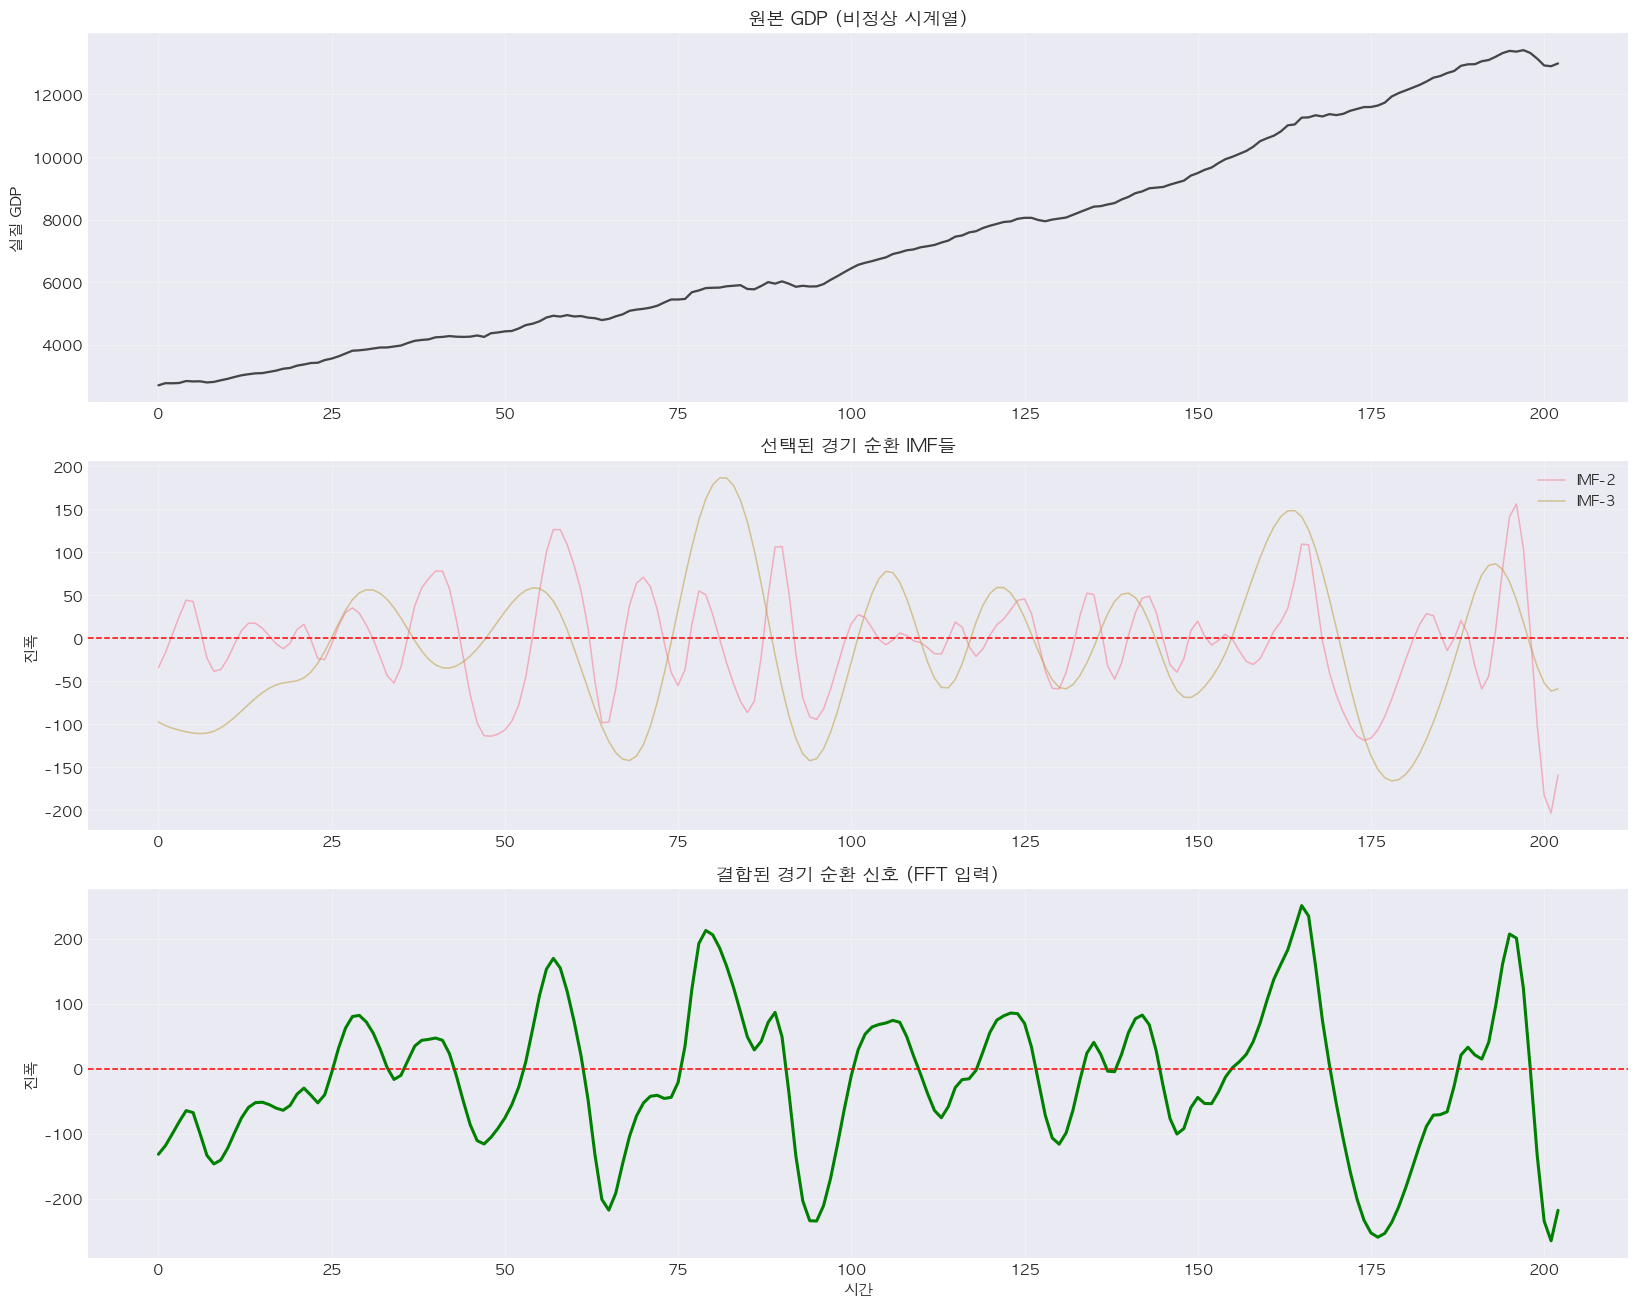

In [104]:
# 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

## 원본 GDP
axes[0].plot(df.index, realgdp_series, color='black', linewidth=1.5, alpha=0.7)
axes[0].set_title('원본 GDP (비정상 시계열)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('실질 GDP', fontsize=10)
axes[0].grid(alpha=0.3)

## 선택된 개별 IMF들
for i in business_cycle_imfs:
    axes[1].plot(df.index, IMFs[i], alpha=0.5, linewidth=1, 
                label=f'IMF-{i+1}')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title(f'선택된 경기 순환 IMF들', fontsize=12, fontweight='bold')
axes[1].set_ylabel('진폭', fontsize=10)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(alpha=0.3)

## 결합된 신호
axes[2].plot(df.index, combined_signal, color='green', linewidth=2)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('결합된 경기 순환 신호 (FFT 입력)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('시간', fontsize=10)
axes[2].set_ylabel('진폭', fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [105]:
# FFT 수행 함수 정의
def perform_fft(signal_data, sampling_rate=4):
    """
    FFT를 수행하고 주파수 스펙트럼을 반환
    
    Parameters:
    - signal_data: 입력 신호
    - sampling_rate: 샘플링 레이트 (분기 데이터는 연 4회)
    
    Returns:
    - freqs: 주파수 배열
    - power: 파워 스펙트럼 (주파수별 강도)
    """
    n = len(signal_data)
    
    # FFT 수행
    fft_values = fft.fft(signal_data)
    
    # 파워 스펙트럼 계산
    power = np.abs(fft_values) ** 2
    
    # 주파수 배열 생성
    freqs = fft.fftfreq(n, d=1/sampling_rate)
    
    # 양의 주파수만 선택 (실수 신호의 대칭성)
    positive_idx = freqs > 0
    freqs = freqs[positive_idx]
    power = power[positive_idx]
    
    return freqs, power

# 결합된 경기 순환 신호에 FFT 적용
freqs, power = perform_fft(combined_signal)

# 주요 주파수 찾기
top_idx = np.argsort(power)[-5:][::-1]

for i, idx in enumerate(top_idx, 1):
    freq = freqs[idx]
    period = 1 / freq if freq > 0 else np.inf
    power_val = power[idx]
    print(f"{i}. 주파수: {freq:.4f} cycles/year | 주기: {period:.2f}년 | 파워: {power_val:.2e}")

periods = 1 / freqs

1. 주파수: 0.1379 cycles/year | 주기: 7.25년 | 파워: 4.41e+07
2. 주파수: 0.1773 cycles/year | 주기: 5.64년 | 파워: 3.53e+07
3. 주파수: 0.0985 cycles/year | 주기: 10.15년 | 파워: 2.88e+07
4. 주파수: 0.1576 cycles/year | 주기: 6.34년 | 파워: 2.81e+07
5. 주파수: 0.1182 cycles/year | 주기: 8.46년 | 파워: 1.61e+07


주파수 분해의 결과는 (주파수, 파워)의 결과로 정리할 수 있습니다. 주파수 대역이 낮을수록 순환 주기가 길고, 대역이 높을수록 순환 주기가 짧아집니다.  

파워 스펙트럼은 이렇게 구한 주파수와 파워의 조합을 선형으로 나타낸 그래프입니다. 주어진 시계열 데이터에서 파워가 높은 주파수일수록 데이터를 설명하는 강도가 높습니다.

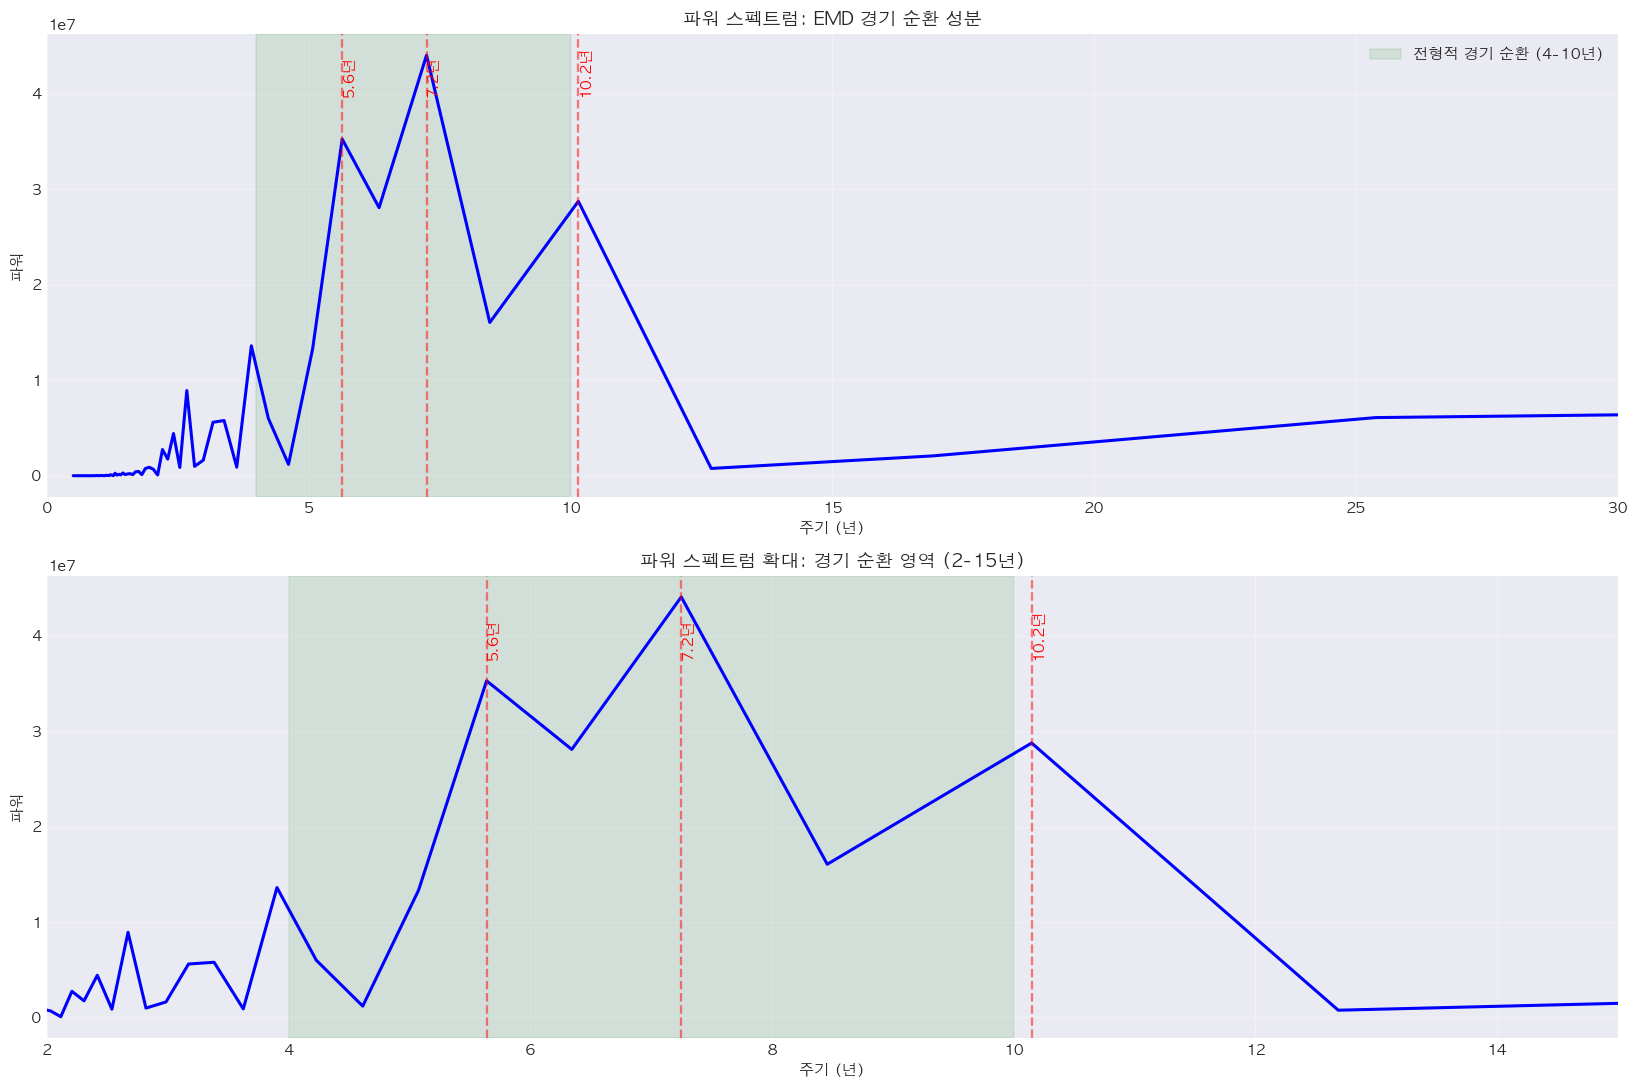

In [107]:
# 파워 스펙트럼 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# [상단] 전체 스펙트럼
axes[0].plot(periods, power, linewidth=2, color='blue')
axes[0].set_title('파워 스펙트럼: EMD 경기 순환 성분', fontsize=12, fontweight='bold')
axes[0].set_xlabel('주기 (년)', fontsize=10)
axes[0].set_ylabel('파워', fontsize=10)
axes[0].set_xlim(0, 30)
axes[0].grid(True, alpha=0.3)

# 주요 주기 표시 (상위 3개)
for idx in top_idx[:3]:
    if periods[idx] <= 30:
        axes[0].axvline(x=periods[idx], color='red', 
                       linestyle='--', alpha=0.5, linewidth=1.5)
        axes[0].text(periods[idx], max(power)*0.9, 
                    f'{periods[idx]:.1f}년',
                    rotation=90, verticalalignment='bottom',
                    fontsize=10, color='red', fontweight='bold')

# 경기 순환 영역 강조
axes[0].axvspan(4, 10, alpha=0.1, color='green', label='전형적 경기 순환 (4-10년)')
axes[0].legend(loc='upper right', fontsize=10)

# [하단] 경기 순환 영역 확대
axes[1].plot(periods, power, linewidth=2, color='blue')
axes[1].set_title('파워 스펙트럼 확대: 경기 순환 영역 (2-15년)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('주기 (년)', fontsize=10)
axes[1].set_ylabel('파워', fontsize=10)
axes[1].set_xlim(2, 15)
axes[1].grid(True, alpha=0.3)

# 주요 주기 표시
for idx in top_idx[:3]:
    if 2 <= periods[idx] <= 15:
        axes[1].axvline(x=periods[idx], color='red', 
                       linestyle='--', alpha=0.5, linewidth=1.5)
        axes[1].text(periods[idx], max(power[np.logical_and(periods>=2, periods<=15)])*0.85, 
                    f'{periods[idx]:.1f}년',
                    rotation=90, verticalalignment='bottom',
                    fontsize=10, color='red', fontweight='bold')

axes[1].axvspan(4, 10, alpha=0.1, color='green')

plt.tight_layout()
plt.show()